In [1]:
# importing libaries

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
class LEMCell(nn.Module):
    def __init__(self, ninp, nhid, dt):
        super(LEMCell, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.dt = dt
        self.inp2hid = nn.Linear(ninp, 4 * nhid)
        self.hid2hid = nn.Linear(nhid, 3 * nhid)
        self.transform_z = nn.Linear(nhid, nhid)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.nhid)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, y, z):
        transformed_inp = self.inp2hid(x)
        transformed_hid = self.hid2hid(y)
        i_dt1, i_dt2, i_z, i_y = transformed_inp.chunk(4, 1)
        h_dt1, h_dt2, h_y = transformed_hid.chunk(3, 1)

        ms_dt_bar = self.dt * torch.sigmoid(i_dt1 + h_dt1)
        ms_dt = self.dt * torch.sigmoid(i_dt2 + h_dt2)

        z = (1. - ms_dt) * z + ms_dt * torch.tanh(i_y + h_y)
        y = (1. - ms_dt_bar) * y + ms_dt_bar * torch.tanh(self.transform_z(z) + i_z)

        return y, z

# Define the LEM model
class LEM(nn.Module):
    def __init__(self, ninp, nhid, nout, dt=1.):
        super(LEM, self).__init__()
        self.nhid = nhid
        self.cell = LEMCell(ninp, nhid, dt)
        self.classifier = nn.Linear(nhid, nout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.kaiming_normal_(param.data)

    def forward(self, input):
        y = input.data.new(input.size(1), self.nhid).zero_()
        z = input.data.new(input.size(1), self.nhid).zero_()
        for x in input:
            y, z = self.cell(x, y, z)
        out = self.classifier(y)
        return out

In [3]:
# Toy problem data
input_size = 256  # number of columns in a dataset
hidden_size = 32  # number of neurons
output_size = 256  
sequence_length = 160  # number of sequences/ number of rows
batch_size = 1
num_epochs = 20000

In [4]:
# importing data

In [5]:
# Load the .mat file
v_data = scipy.io.loadmat('v.mat')
h_data = scipy.io.loadmat('h.mat')
x_data = scipy.io.loadmat('x.mat')
h_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Jul 20 15:02:48 2023',
 '__version__': '1.0',
 '__globals__': [],
 'h': array([[0.03949907, 0.03945555, 0.03968762, ..., 0.04081577, 0.04034067,
         0.03995187],
        [0.03949522, 0.03972834, 0.04007071, ..., 0.0406224 , 0.0405568 ,
         0.04021852],
        [0.03980837, 0.03966293, 0.04008707, ..., 0.04077249, 0.04050591,
         0.04019281],
        ...,
        [0.04915863, 0.04935256, 0.04961976, ..., 0.04917885, 0.04899574,
         0.04881741],
        [0.04904458, 0.04916197, 0.04943338, ..., 0.04902097, 0.04897786,
         0.04875013],
        [0.04913692, 0.04932824, 0.04941899, ..., 0.04888785, 0.0488357 ,
         0.04855312]])}

In [6]:
x = x_data['X']
u = h_data['h']

In [7]:
print(x.shape)
print(u.shape)
u

(201, 256)
(201, 256)


array([[0.03949907, 0.03945555, 0.03968762, ..., 0.04081577, 0.04034067,
        0.03995187],
       [0.03949522, 0.03972834, 0.04007071, ..., 0.0406224 , 0.0405568 ,
        0.04021852],
       [0.03980837, 0.03966293, 0.04008707, ..., 0.04077249, 0.04050591,
        0.04019281],
       ...,
       [0.04915863, 0.04935256, 0.04961976, ..., 0.04917885, 0.04899574,
        0.04881741],
       [0.04904458, 0.04916197, 0.04943338, ..., 0.04902097, 0.04897786,
        0.04875013],
       [0.04913692, 0.04932824, 0.04941899, ..., 0.04888785, 0.0488357 ,
        0.04855312]])

In [8]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [9]:
input_data = u[0:160,:]
target_data = u[1:161, :]

test_data = u[160, :]
#test_target = u[161:201, :]

print("test data shape", test_data.shape)
#print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

test data shape (256,)
input data shape (160, 256)
Target data shape (160, 256)


In [10]:
# Convert data to tensors
input_tensor = torch.tensor(input_data).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)

input tensor shape torch.Size([1, 160, 256])
Target tensor shape torch.Size([1, 160, 256])


In [11]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data).view(batch_size, 1, input_size).float()
#test_target_tensor = torch.tensor(test_target).view(batch_size, 40, output_size).float()


In [13]:
# Create LEM instance
lem = LEM(input_size, hidden_size, output_size, dt=0.1)

# Loss and optimizer
criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(lem.parameters(), lr=0.001)
optimizer = torch.optim.LBFGS(lem.parameters(), lr=0.1)



# Training loop
for epoch in range(num_epochs):
    def closure():
        optimizer.zero_grad()
        output = lem(input_tensor)
        loss = criterion(output, target_tensor)
        loss.backward()
        return loss

    optimizer.step(closure)

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {closure().item():.16f}')

    # Flatten prediction tensor
    prediction = lem(input_tensor).view(-1).detach().numpy()


# # Training loop
# for epoch in range(num_epochs):
#     # Forward pass
#     output = lem(input_tensor)
#     loss = criterion(output, target_tensor)

#     # Backward and optimize
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # Print progress
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item():.6f}')




Epoch: 10/20000, Loss: 0.0001531622547191
Epoch: 20/20000, Loss: 0.0000556913655601
Epoch: 30/20000, Loss: 0.0000173606149474
Epoch: 40/20000, Loss: 0.0000080684130808
Epoch: 50/20000, Loss: 0.0000063897809923
Epoch: 60/20000, Loss: 0.0000053548255892
Epoch: 70/20000, Loss: 0.0000040599725253
Epoch: 80/20000, Loss: 0.0000030928488286
Epoch: 90/20000, Loss: 0.0000029393174827
Epoch: 100/20000, Loss: 0.0000029374455153
Epoch: 110/20000, Loss: 0.0000029368952710
Epoch: 120/20000, Loss: 0.0000029368952710
Epoch: 130/20000, Loss: 0.0000029368952710
Epoch: 140/20000, Loss: 0.0000029368952710
Epoch: 150/20000, Loss: 0.0000029368952710
Epoch: 160/20000, Loss: 0.0000029368952710
Epoch: 170/20000, Loss: 0.0000029368952710
Epoch: 180/20000, Loss: 0.0000029368952710
Epoch: 190/20000, Loss: 0.0000029368952710
Epoch: 200/20000, Loss: 0.0000029368952710
Epoch: 210/20000, Loss: 0.0000029368952710
Epoch: 220/20000, Loss: 0.0000029368952710
Epoch: 230/20000, Loss: 0.0000029368952710
Epoch: 240/20000, Lo

Epoch: 1910/20000, Loss: 0.0000029368952710
Epoch: 1920/20000, Loss: 0.0000029368952710
Epoch: 1930/20000, Loss: 0.0000029368952710
Epoch: 1940/20000, Loss: 0.0000029368952710
Epoch: 1950/20000, Loss: 0.0000029368952710
Epoch: 1960/20000, Loss: 0.0000029368952710
Epoch: 1970/20000, Loss: 0.0000029368952710
Epoch: 1980/20000, Loss: 0.0000029368952710
Epoch: 1990/20000, Loss: 0.0000029368952710
Epoch: 2000/20000, Loss: 0.0000029368952710
Epoch: 2010/20000, Loss: 0.0000029368952710
Epoch: 2020/20000, Loss: 0.0000029368952710
Epoch: 2030/20000, Loss: 0.0000029368952710
Epoch: 2040/20000, Loss: 0.0000029368952710
Epoch: 2050/20000, Loss: 0.0000029368952710
Epoch: 2060/20000, Loss: 0.0000029368952710
Epoch: 2070/20000, Loss: 0.0000029368952710
Epoch: 2080/20000, Loss: 0.0000029368952710
Epoch: 2090/20000, Loss: 0.0000029368952710
Epoch: 2100/20000, Loss: 0.0000029368952710
Epoch: 2110/20000, Loss: 0.0000029368952710
Epoch: 2120/20000, Loss: 0.0000029368952710
Epoch: 2130/20000, Loss: 0.00000

Epoch: 3790/20000, Loss: 0.0000029368952710
Epoch: 3800/20000, Loss: 0.0000029368952710
Epoch: 3810/20000, Loss: 0.0000029368952710
Epoch: 3820/20000, Loss: 0.0000029368952710
Epoch: 3830/20000, Loss: 0.0000029368952710
Epoch: 3840/20000, Loss: 0.0000029368952710
Epoch: 3850/20000, Loss: 0.0000029368952710
Epoch: 3860/20000, Loss: 0.0000029368952710
Epoch: 3870/20000, Loss: 0.0000029368952710
Epoch: 3880/20000, Loss: 0.0000029368952710
Epoch: 3890/20000, Loss: 0.0000029368952710
Epoch: 3900/20000, Loss: 0.0000029368952710
Epoch: 3910/20000, Loss: 0.0000029368952710
Epoch: 3920/20000, Loss: 0.0000029368952710
Epoch: 3930/20000, Loss: 0.0000029368952710
Epoch: 3940/20000, Loss: 0.0000029368952710
Epoch: 3950/20000, Loss: 0.0000029368952710
Epoch: 3960/20000, Loss: 0.0000029368952710
Epoch: 3970/20000, Loss: 0.0000029368952710
Epoch: 3980/20000, Loss: 0.0000029368952710
Epoch: 3990/20000, Loss: 0.0000029368952710
Epoch: 4000/20000, Loss: 0.0000029368952710
Epoch: 4010/20000, Loss: 0.00000

Epoch: 5670/20000, Loss: 0.0000029368952710
Epoch: 5680/20000, Loss: 0.0000029368952710
Epoch: 5690/20000, Loss: 0.0000029368952710
Epoch: 5700/20000, Loss: 0.0000029368952710
Epoch: 5710/20000, Loss: 0.0000029368952710
Epoch: 5720/20000, Loss: 0.0000029368952710
Epoch: 5730/20000, Loss: 0.0000029368952710
Epoch: 5740/20000, Loss: 0.0000029368952710
Epoch: 5750/20000, Loss: 0.0000029368952710
Epoch: 5760/20000, Loss: 0.0000029368952710
Epoch: 5770/20000, Loss: 0.0000029368952710
Epoch: 5780/20000, Loss: 0.0000029368952710
Epoch: 5790/20000, Loss: 0.0000029368952710
Epoch: 5800/20000, Loss: 0.0000029368952710
Epoch: 5810/20000, Loss: 0.0000029368952710
Epoch: 5820/20000, Loss: 0.0000029368952710
Epoch: 5830/20000, Loss: 0.0000029368952710
Epoch: 5840/20000, Loss: 0.0000029368952710
Epoch: 5850/20000, Loss: 0.0000029368952710
Epoch: 5860/20000, Loss: 0.0000029368952710
Epoch: 5870/20000, Loss: 0.0000029368952710
Epoch: 5880/20000, Loss: 0.0000029368952710
Epoch: 5890/20000, Loss: 0.00000

Epoch: 7550/20000, Loss: 0.0000029368952710
Epoch: 7560/20000, Loss: 0.0000029368952710
Epoch: 7570/20000, Loss: 0.0000029368952710
Epoch: 7580/20000, Loss: 0.0000029368952710
Epoch: 7590/20000, Loss: 0.0000029368952710
Epoch: 7600/20000, Loss: 0.0000029368952710
Epoch: 7610/20000, Loss: 0.0000029368952710
Epoch: 7620/20000, Loss: 0.0000029368952710
Epoch: 7630/20000, Loss: 0.0000029368952710
Epoch: 7640/20000, Loss: 0.0000029368952710
Epoch: 7650/20000, Loss: 0.0000029368952710
Epoch: 7660/20000, Loss: 0.0000029368952710
Epoch: 7670/20000, Loss: 0.0000029368952710
Epoch: 7680/20000, Loss: 0.0000029368952710
Epoch: 7690/20000, Loss: 0.0000029368952710
Epoch: 7700/20000, Loss: 0.0000029368952710
Epoch: 7710/20000, Loss: 0.0000029368952710
Epoch: 7720/20000, Loss: 0.0000029368952710
Epoch: 7730/20000, Loss: 0.0000029368952710
Epoch: 7740/20000, Loss: 0.0000029368952710
Epoch: 7750/20000, Loss: 0.0000029368952710
Epoch: 7760/20000, Loss: 0.0000029368952710
Epoch: 7770/20000, Loss: 0.00000

Epoch: 9430/20000, Loss: 0.0000029368952710
Epoch: 9440/20000, Loss: 0.0000029368952710
Epoch: 9450/20000, Loss: 0.0000029368952710
Epoch: 9460/20000, Loss: 0.0000029368952710
Epoch: 9470/20000, Loss: 0.0000029368952710
Epoch: 9480/20000, Loss: 0.0000029368952710
Epoch: 9490/20000, Loss: 0.0000029368952710
Epoch: 9500/20000, Loss: 0.0000029368952710
Epoch: 9510/20000, Loss: 0.0000029368952710
Epoch: 9520/20000, Loss: 0.0000029368952710
Epoch: 9530/20000, Loss: 0.0000029368952710
Epoch: 9540/20000, Loss: 0.0000029368952710
Epoch: 9550/20000, Loss: 0.0000029368952710
Epoch: 9560/20000, Loss: 0.0000029368952710
Epoch: 9570/20000, Loss: 0.0000029368952710
Epoch: 9580/20000, Loss: 0.0000029368952710
Epoch: 9590/20000, Loss: 0.0000029368952710
Epoch: 9600/20000, Loss: 0.0000029368952710
Epoch: 9610/20000, Loss: 0.0000029368952710
Epoch: 9620/20000, Loss: 0.0000029368952710
Epoch: 9630/20000, Loss: 0.0000029368952710
Epoch: 9640/20000, Loss: 0.0000029368952710
Epoch: 9650/20000, Loss: 0.00000

Epoch: 11270/20000, Loss: 0.0000029368952710
Epoch: 11280/20000, Loss: 0.0000029368952710
Epoch: 11290/20000, Loss: 0.0000029368952710
Epoch: 11300/20000, Loss: 0.0000029368952710
Epoch: 11310/20000, Loss: 0.0000029368952710
Epoch: 11320/20000, Loss: 0.0000029368952710
Epoch: 11330/20000, Loss: 0.0000029368952710
Epoch: 11340/20000, Loss: 0.0000029368952710
Epoch: 11350/20000, Loss: 0.0000029368952710
Epoch: 11360/20000, Loss: 0.0000029368952710
Epoch: 11370/20000, Loss: 0.0000029368952710
Epoch: 11380/20000, Loss: 0.0000029368952710
Epoch: 11390/20000, Loss: 0.0000029368952710
Epoch: 11400/20000, Loss: 0.0000029368952710
Epoch: 11410/20000, Loss: 0.0000029368952710
Epoch: 11420/20000, Loss: 0.0000029368952710
Epoch: 11430/20000, Loss: 0.0000029368952710
Epoch: 11440/20000, Loss: 0.0000029368952710
Epoch: 11450/20000, Loss: 0.0000029368952710
Epoch: 11460/20000, Loss: 0.0000029368952710
Epoch: 11470/20000, Loss: 0.0000029368952710
Epoch: 11480/20000, Loss: 0.0000029368952710
Epoch: 114

Epoch: 13110/20000, Loss: 0.0000029368952710
Epoch: 13120/20000, Loss: 0.0000029368952710
Epoch: 13130/20000, Loss: 0.0000029368952710
Epoch: 13140/20000, Loss: 0.0000029368952710
Epoch: 13150/20000, Loss: 0.0000029368952710
Epoch: 13160/20000, Loss: 0.0000029368952710
Epoch: 13170/20000, Loss: 0.0000029368952710
Epoch: 13180/20000, Loss: 0.0000029368952710
Epoch: 13190/20000, Loss: 0.0000029368952710
Epoch: 13200/20000, Loss: 0.0000029368952710
Epoch: 13210/20000, Loss: 0.0000029368952710
Epoch: 13220/20000, Loss: 0.0000029368952710
Epoch: 13230/20000, Loss: 0.0000029368952710
Epoch: 13240/20000, Loss: 0.0000029368952710
Epoch: 13250/20000, Loss: 0.0000029368952710
Epoch: 13260/20000, Loss: 0.0000029368952710
Epoch: 13270/20000, Loss: 0.0000029368952710
Epoch: 13280/20000, Loss: 0.0000029368952710
Epoch: 13290/20000, Loss: 0.0000029368952710
Epoch: 13300/20000, Loss: 0.0000029368952710
Epoch: 13310/20000, Loss: 0.0000029368952710
Epoch: 13320/20000, Loss: 0.0000029368952710
Epoch: 133

Epoch: 14950/20000, Loss: 0.0000029368952710
Epoch: 14960/20000, Loss: 0.0000029368952710
Epoch: 14970/20000, Loss: 0.0000029368952710
Epoch: 14980/20000, Loss: 0.0000029368952710
Epoch: 14990/20000, Loss: 0.0000029368952710
Epoch: 15000/20000, Loss: 0.0000029368952710
Epoch: 15010/20000, Loss: 0.0000029368952710
Epoch: 15020/20000, Loss: 0.0000029368952710
Epoch: 15030/20000, Loss: 0.0000029368952710
Epoch: 15040/20000, Loss: 0.0000029368952710
Epoch: 15050/20000, Loss: 0.0000029368952710
Epoch: 15060/20000, Loss: 0.0000029368952710
Epoch: 15070/20000, Loss: 0.0000029368952710
Epoch: 15080/20000, Loss: 0.0000029368952710
Epoch: 15090/20000, Loss: 0.0000029368952710
Epoch: 15100/20000, Loss: 0.0000029368952710
Epoch: 15110/20000, Loss: 0.0000029368952710
Epoch: 15120/20000, Loss: 0.0000029368952710
Epoch: 15130/20000, Loss: 0.0000029368952710
Epoch: 15140/20000, Loss: 0.0000029368952710
Epoch: 15150/20000, Loss: 0.0000029368952710
Epoch: 15160/20000, Loss: 0.0000029368952710
Epoch: 151

Epoch: 16790/20000, Loss: 0.0000029368952710
Epoch: 16800/20000, Loss: 0.0000029368952710
Epoch: 16810/20000, Loss: 0.0000029368952710
Epoch: 16820/20000, Loss: 0.0000029368952710
Epoch: 16830/20000, Loss: 0.0000029368952710
Epoch: 16840/20000, Loss: 0.0000029368952710
Epoch: 16850/20000, Loss: 0.0000029368952710
Epoch: 16860/20000, Loss: 0.0000029368952710
Epoch: 16870/20000, Loss: 0.0000029368952710
Epoch: 16880/20000, Loss: 0.0000029368952710
Epoch: 16890/20000, Loss: 0.0000029368952710
Epoch: 16900/20000, Loss: 0.0000029368952710
Epoch: 16910/20000, Loss: 0.0000029368952710
Epoch: 16920/20000, Loss: 0.0000029368952710
Epoch: 16930/20000, Loss: 0.0000029368952710
Epoch: 16940/20000, Loss: 0.0000029368952710
Epoch: 16950/20000, Loss: 0.0000029368952710
Epoch: 16960/20000, Loss: 0.0000029368952710
Epoch: 16970/20000, Loss: 0.0000029368952710
Epoch: 16980/20000, Loss: 0.0000029368952710
Epoch: 16990/20000, Loss: 0.0000029368952710
Epoch: 17000/20000, Loss: 0.0000029368952710
Epoch: 170

Epoch: 18630/20000, Loss: 0.0000029368952710
Epoch: 18640/20000, Loss: 0.0000029368952710
Epoch: 18650/20000, Loss: 0.0000029368952710
Epoch: 18660/20000, Loss: 0.0000029368952710
Epoch: 18670/20000, Loss: 0.0000029368952710
Epoch: 18680/20000, Loss: 0.0000029368952710
Epoch: 18690/20000, Loss: 0.0000029368952710
Epoch: 18700/20000, Loss: 0.0000029368952710
Epoch: 18710/20000, Loss: 0.0000029368952710
Epoch: 18720/20000, Loss: 0.0000029368952710
Epoch: 18730/20000, Loss: 0.0000029368952710
Epoch: 18740/20000, Loss: 0.0000029368952710
Epoch: 18750/20000, Loss: 0.0000029368952710
Epoch: 18760/20000, Loss: 0.0000029368952710
Epoch: 18770/20000, Loss: 0.0000029368952710
Epoch: 18780/20000, Loss: 0.0000029368952710
Epoch: 18790/20000, Loss: 0.0000029368952710
Epoch: 18800/20000, Loss: 0.0000029368952710
Epoch: 18810/20000, Loss: 0.0000029368952710
Epoch: 18820/20000, Loss: 0.0000029368952710
Epoch: 18830/20000, Loss: 0.0000029368952710
Epoch: 18840/20000, Loss: 0.0000029368952710
Epoch: 188

In [14]:
print(test_tensor.shape)
prediction_tensor = torch.zeros(1, 40, 256).float()
print(prediction_tensor.shape)

torch.Size([1, 1, 256])
torch.Size([1, 40, 256])


In [15]:
test_tensor.shape

torch.Size([1, 1, 256])

(1, 256)
(1, 201)
(201, 256)


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.8/dist-packages/matplotlib/contour.py:1180: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg).astype(np.float64)


<Figure size 432x288 with 0 Axes>

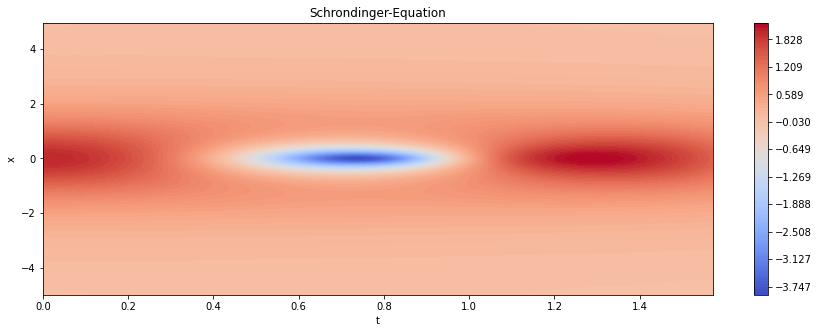

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('NLS.mat')

# Following is the code to plot the data u vs x and t. u is 256*100
# matrix. Use first 75 columns for training and 25 for testing :)

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['tt']
u1 = mat_data['uu']

# Use the loaded variables as needed
print(x.shape)
print(t.shape)
print(u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u1), np.max(u1), 100)

# Plot the contour
plt.figure()
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u1.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Schrondinger-Equation')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

In [17]:

u1.shape
u1_new = np.abs(u1.T)
u1_new

array([[0.02695056, 0.02802405, 0.02914028, ..., 0.03030097, 0.02914028,
        0.02802405],
       [0.02830826, 0.02846008, 0.02892091, ..., 0.02978105, 0.02892091,
        0.02846008],
       [0.02890662, 0.02901981, 0.02934887, ..., 0.02994636, 0.02934887,
        0.02901981],
       ...,
       [0.05102925, 0.05110305, 0.05126979, ..., 0.05150113, 0.05126979,
        0.05110305],
       [0.05115212, 0.05109786, 0.05112245, ..., 0.05130366, 0.05112245,
        0.05109786],
       [0.05105769, 0.05101199, 0.05109009, ..., 0.05132839, 0.05109009,
        0.05101199]])

(256, 1)
(256, 1)


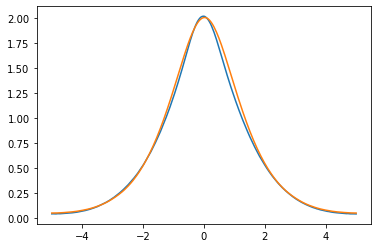

In [18]:
with torch.no_grad():
    prediction = lem(test_tensor)
    prediction = prediction.view(1, 1, 256).float()
    prediction_tensor[:, 0, :] = prediction
    for i in range(39):
        prediction = lem(prediction)
        prediction = prediction.view(1, 1, 256).float()
        prediction_tensor[:, i+1, :] = prediction
        

# prediction = torch.squeeze(prediction)
# prediction = prediction.reshape(-1, 1)

final_out = prediction.detach().numpy().reshape(-1,1)
final_true = u1_new[-1,:].reshape(-1,1)




x1 = np.linspace(-5, 5, 256)
print(final_out.shape)
print(final_true.shape)



plt.plot(x1, final_out)
plt.plot(x1, final_true)
plt.show()

In [19]:
prediction_tensor.shape
prediction_tensor = torch.squeeze(prediction_tensor)

In [20]:
from matplotlib.font_manager import FontProperties
plt.rcParams['axes.unicode_minus'] = False
font_path = 'times-new-roman.ttf'
custom_font = FontProperties(fname=font_path)

(256, 1)
(256, 1)


NameError: name 'FixedLocator' is not defined

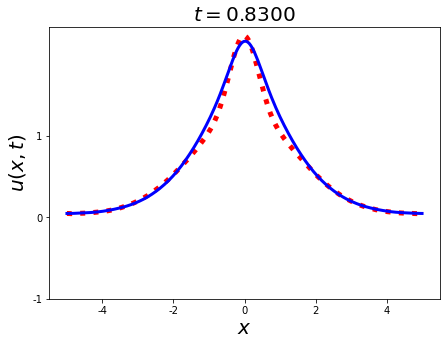

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(7, 5))  # You can adjust the width (8 inches) and height (5 inches) as needed

# Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# # Perform the prediction
# with torch.no_grad():
#     prediction = lem(test_tensor)

final_time_output = prediction_tensor[-30, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u1_new[-30, :].reshape(-1, 1)

print(final_out.shape)
print(final_true.shape)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x1, final_out, color='red', linestyle='dotted', linewidth=5, label='Prediction')
ax.plot(x1, final_true, color='blue', linestyle='solid', linewidth=3, label='True')

# Set the axis labels
ax.set_xlabel("$x$", fontsize=20, color='black', fontproperties=custom_font)
ax.set_ylabel("$u(x, t)$", fontsize=20, color='black', fontproperties=custom_font)

# Set the title
ax.set_title("$t = 0.8300$", fontsize=20, color='black', fontproperties=custom_font)

# Set the y-axis ticks to only -1, 0, and 1
ax.set_yticks([-1, 0, 1])

# Set the number of ticks for x-axis to 3
num_ticks = 3
x_ticks = np.linspace(np.min(x), np.max(x), num_ticks)

ax.xaxis.set_major_locator(FixedLocator(x_ticks))

plt.xticks(fontsize=20, fontproperties=custom_font)
plt.yticks(fontsize=20, fontproperties=custom_font)

# Set the legend
# ax.legend()

plt.savefig('fig3_r.pdf', dpi=500)
plt.savefig('Fig3_r.png', dpi=500)
# Show the plot
plt.show()


(256, 1)
(256, 1)


NameError: name 'FixedLocator' is not defined

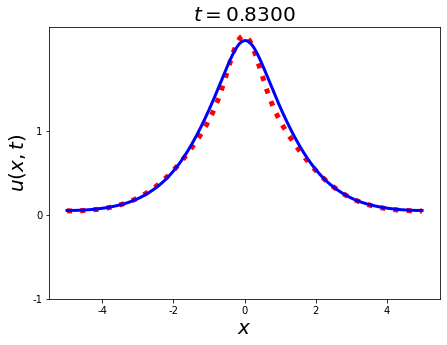

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(7, 5))  # You can adjust the width (8 inches) and height (5 inches) as needed

# Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# # Perform the prediction
# with torch.no_grad():
#     prediction = lem(test_tensor)

final_time_output = prediction_tensor[-20, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u1_new[-20, :].reshape(-1, 1)

print(final_out.shape)
print(final_true.shape)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x1, final_out, color='red', linestyle='dotted', linewidth=5, label='Prediction')
ax.plot(x1, final_true, color='blue', linestyle='solid', linewidth=3, label='True')

# Set the axis labels
ax.set_xlabel("$x$", fontsize=20, color='black', fontproperties=custom_font)
ax.set_ylabel("$u(x, t)$", fontsize=20, color='black', fontproperties=custom_font)

# Set the title
ax.set_title("$t = 0.8300$", fontsize=20, color='black', fontproperties=custom_font)

# Set the y-axis ticks to only -1, 0, and 1
ax.set_yticks([-1, 0, 1])

# Set the number of ticks for x-axis to 3
num_ticks = 3
x_ticks = np.linspace(np.min(x), np.max(x), num_ticks)

ax.xaxis.set_major_locator(FixedLocator(x_ticks))

plt.xticks(fontsize=20, fontproperties=custom_font)
plt.yticks(fontsize=20, fontproperties=custom_font)

# Set the legend
# ax.legend()

plt.savefig('fig3_r.pdf', dpi=500)
plt.savefig('Fig3_r.png', dpi=500)
# Show the plot
plt.show()


(256, 1)
(256, 1)


NameError: name 'FixedLocator' is not defined

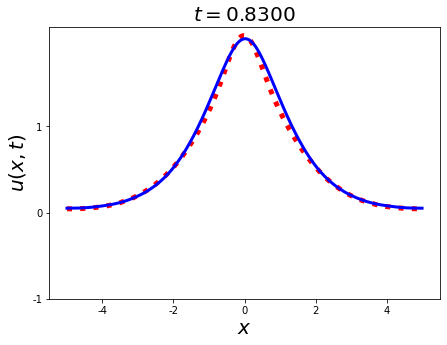

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(7, 5))  # You can adjust the width (8 inches) and height (5 inches) as needed

# Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# # Perform the prediction
# with torch.no_grad():
#     prediction = lem(test_tensor)

final_time_output = prediction_tensor[-10, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u1_new[-10, :].reshape(-1, 1)

print(final_out.shape)
print(final_true.shape)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x1, final_out, color='red', linestyle='dotted', linewidth=5, label='Prediction')
ax.plot(x1, final_true, color='blue', linestyle='solid', linewidth=3, label='True')

# Set the axis labels
ax.set_xlabel("$x$", fontsize=20, color='black', fontproperties=custom_font)
ax.set_ylabel("$u(x, t)$", fontsize=20, color='black', fontproperties=custom_font)

# Set the title
ax.set_title("$t = 0.8300$", fontsize=20, color='black', fontproperties=custom_font)

# Set the y-axis ticks to only -1, 0, and 1
ax.set_yticks([-1, 0, 1])

# Set the number of ticks for x-axis to 3
num_ticks = 3
x_ticks = np.linspace(np.min(x), np.max(x), num_ticks)

ax.xaxis.set_major_locator(FixedLocator(x_ticks))

plt.xticks(fontsize=20, fontproperties=custom_font)
plt.yticks(fontsize=20, fontproperties=custom_font)

# Set the legend
# ax.legend()

plt.savefig('fig3_r.pdf', dpi=500)
plt.savefig('Fig3_r.png', dpi=500)
# Show the plot
plt.show()


In [27]:
u_test_full = u1_new
u_test_full.shape

(201, 256)

In [28]:
# Exact Solution

u_test = u1_new
u_test_full = u_test[160:200, :]

In [29]:
prediction_tensor.shape
u_test_full.shape

(40, 256)

In [30]:
# Extrapolation

prediction_tensor = torch.squeeze(prediction_tensor)
k1 = ( prediction_tensor - u_test_full)**2
u_test_full_tensor = torch.tensor(u_test_full**2)
u_test_full_tensor.shape

torch.Size([40, 256])

### L2 norm

In [31]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(k1)/ torch.mean(u_test_full_tensor)

print("Relative Error Test: ", relative_error_test.item(), "%")

Relative Error Test:  0.004880395129128665 %


### maximum absolute error

In [32]:
R_abs = torch.max(torch.abs(prediction_tensor - u_test_full))
print(R_abs)

tensor(0.2746, dtype=torch.float64)


### explained variance

In [33]:
import torch

a = prediction_tensor
b = u_test_full
# Assuming 'a' is your predicted values (model's predictions) and 'b' is the true values (ground truth)
# Make sure 'a' and 'b' are PyTorch tensors
a = torch.tensor(a)
b = torch.tensor(b)
# Calculate the mean of 'b'
mean_b = torch.mean(b)

# Calculate the Explained Variance Score
numerator = torch.var(b - a)  # Variance of the differences between 'b' and 'a'
denominator = torch.var(b)    # Variance of 'b'
evs = 1 - numerator / denominator

print("Explained Variance Score:", evs.item())

Explained Variance Score: 0.992439625620205


/tmp/ipykernel_55355/2104891356.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(a)


### MEan absolute error

In [34]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(torch.abs(prediction_tensor - u_test_full))

print("Relative Error Test: ", relative_error_test, "%")

Relative Error Test:  tensor(0.0346, dtype=torch.float64) %


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('NLS.mat')

# Following is the code to plot the data u vs x and t. u is 256*100
# matrix. Use first 75 columns for training and 25 for testing :)

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['tt']
u = mat_data['uu']

# Use the loaded variables as needed
print(x.shape)
print(t.shape)
print(u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u), np.max(u), 100)

# Plot the contour
plt.figure()
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Schrondinger-Equation')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

### 80 percent PINN solution 20 lem prediction in contour plot

In [ ]:
prediction.shape

In [ ]:
input_tensor.shape

In [ ]:
conc_u = torch.squeeze(input_tensor)

In [ ]:
concatenated_tensor = torch.cat((conc_u, prediction), dim=0)

concatenated_tensor.shape

In [ ]:
t

In [ ]:
t1 = np.linspace(0, 1.5707 , 200)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()

# Define custom color levels
X, T = np.meshgrid(x, t1)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 100)

# Plot the contour
plt.figure(figsize=(15, 5))
CS1 = plt.contourf(T, X, concatenated_array, levels=c_levels, cmap='coolwarm')

# Create a custom font with Times New Roman
plt.rcParams['figure.figsize'] = [10, 4]

from matplotlib.font_manager import FontProperties
plt.rcParams['axes.unicode_minus'] = False
font_path = 'times-new-roman.ttf'
custom_font = FontProperties(fname=font_path)

cbar1 = plt.colorbar(CS1)
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

for t in cbar1.ax.get_yticklabels():
    t.set_fontproperties(custom_font)
    t.set_fontsize(20)

plt.xlabel('$t$', fontsize=20, fontproperties=custom_font)
plt.ylabel('$x$', fontsize=20, fontproperties=custom_font)
plt.title('$u(x, t)$', fontsize=20, fontproperties=custom_font)
plt.xticks(fontsize=20, fontproperties=custom_font)
plt.yticks(fontsize=20, fontproperties=custom_font)

# Add a dotted line at t = 0.8
plt.axvline(x=1.26449, color='black', linestyle='dotted')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))
cbar1.locator = FixedLocator(c_ticks)

plt.savefig('Schr_80_20.pdf', dpi=300)
plt.savefig('schr_80_20.png', dpi=300)
# Show the plot
plt.show()
